In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import itertools
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [3]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Training/'.
There are 0 directories and 1457 images in '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'.
There are 0 directories and 1595 images in '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'.
There are 0 directories and 1339 images in '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'.
There are 0 directories and 1321 images in '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'.


In [4]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary'.
There are 0 directories and 405 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor'.
There are 0 directories and 306 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma'.


In [5]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (512, 512)


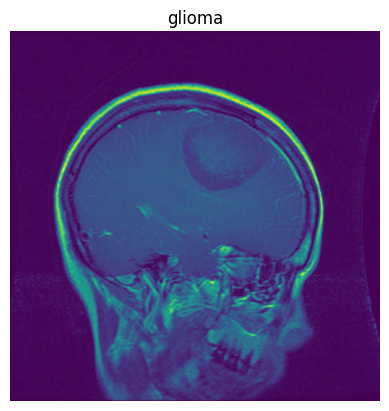

In [6]:
img = view_random_image(target_dir=test_dir,
                        target_class="glioma")

In [7]:
EPOCHS = 50
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [8]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def augment_image(image, label):
    # Apply augmentation transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Apply the width and height shifts
    width_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[0], tf.float32)
    image = tfa.image.translate(image, [width_shift, height_shift])

    return image, label

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [10]:
# Apply augmentation to the training dataset using the map function
train_dataset_augmented = train_data.map(augment_image)

In [11]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights=None, include_top=False, input_tensor=input_layer)

    # Load the weights from the local file (specify the path)
    baseModel.load_weights('/kaggle/input/vgg19-weight/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # FC layer
    x = Flatten(name="flatten")(x)

    # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    opt = Adam(lr=1e3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

# Create the model
model = Combined_model()

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step)))]
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')

In [13]:
history = model.fit(train_dataset_augmented,
                    epochs=50,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data = test_data,
                    callbacks=[checkpoint])

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.7712
Epoch 1: val_accuracy improved from -inf to 0.78719, saving model to best_model.h5
179/179 [==============================] - 63s 291ms/step - loss: 1.1565 - accuracy: 0.7712 - val_loss: 0.9777 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.8389
Epoch 2: val_accuracy improved from 0.78719 to 0.87033, saving model to best_model.h5
179/179 [==============================] - 45s 248ms/step - loss: 0.4736 - accuracy: 0.8389 - val_loss: 0.4270 - val_accuracy: 0.8703 - lr: 9.5000e-04
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8683
Epoch 3: val_accuracy did not improve from 0.87033
179/179 [==============================] - 44s 244ms/step - loss: 0.3855 - accuracy: 0.8683 - val_loss: 0.4125 - val_accuracy: 0.8688 - lr: 9.0250e-04
Epoch 4/50
179/179 [=======================

In [39]:
history.history.keys()   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [43]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss).item()
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc).item()
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'


data = {
    "tr_acc": tr_acc,
    "tr_loss": tr_loss,
    "val_acc": val_acc,
    "val_loss": val_loss,
    "index_loss": index_loss,
    "val_lowest": val_lowest,
    "index_acc": index_acc,
    "acc_highest": acc_highest,
    "Epochs": Epochs,
    "loss_label": loss_label,
    "acc_label": acc_label
}

# Define the file name
file_name = "training_metrics.json"

# Write data to a JSON file
with open(file_name, "w") as json_file:
    json.dump(data, json_file)

print("Data saved to", file_name)

In [14]:
model.load_weights('/kaggle/working/best_model.h5')
_, accuracy = model.evaluate(test_data)    
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

41/41 [==============================] - 7s 165ms/step - loss: 0.1251 - accuracy: 0.9786
Validation accuracy: 97.86%


In [15]:
pred_probs = model.predict(test_data, verbose=1)

41/41 [==============================] - 7s 163ms/step


In [36]:
train_score = model.evaluate(train_data, verbose=1)
valid_score = model.evaluate(test_data, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")          


In [37]:
with open('model_scores.txt', 'w') as file:
    file.write("Train Loss: {}\n".format(train_score[0]))
    file.write("Train Accuracy: {}\n".format(train_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Validation Loss: {}\n".format(valid_score[0]))
    file.write("Validation Accuracy: {}\n".format(valid_score[1]))

print("Scores saved successfully.")

In [16]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [17]:
target_names = ['Glioma', 'Meningioma', 'No Tumor','Pituitary']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Glioma     0.9894    0.9300    0.9588       300
  Meningioma     0.9377    0.9837    0.9601       306
    No Tumor     0.9975    0.9975    0.9975       405
   Pituitary     0.9868    0.9967    0.9917       300

    accuracy                         0.9786      1311
   macro avg     0.9778    0.9770    0.9770      1311
weighted avg     0.9792    0.9786    0.9786      1311



In [23]:
report = classification_report(y_labels, pred_classes, target_names=target_names, digits=4)
with open('classification_report.txt', 'w') as file:
    file.write(report)

In [18]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Specificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 279
False Positives: 21
True Negatives: 1008
False Negatives: 3
Specificity: 0.9795918367346939
Sensitivity: 0.9893617021276596


In [27]:
TP = int(TP)
FP = int(FP)
TN = int(TN)
FN = int(FN)

data = {
    "True Positives": TP,
    "False Positives": FP,
    "True Negatives": TN,
    "False Negatives": FN,
    "Specificity": spesificity,
    "Sensitivity": sensitivity
}

# Define the file name
file_name = "metrics.json"
import json
# Write data to a JSON file
with open(file_name, "w") as json_file:
    json.dump(data, json_file)

print("Data saved to", file_name)

Data saved to metrics.json


In [28]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.grid(False)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    
    plt.savefig('confusion_matrix.png')

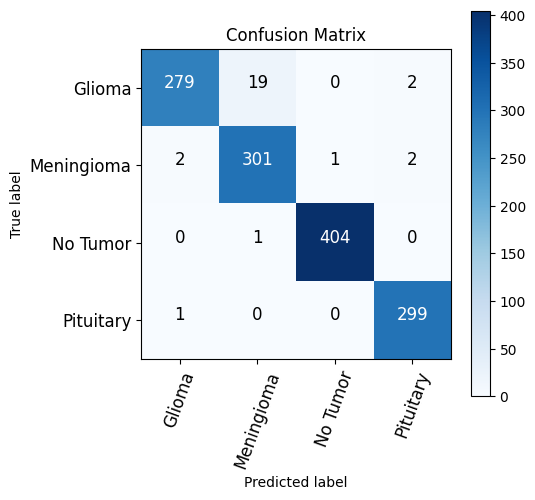

In [29]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(5, 5),
                      text_size=12,
                      norm=False,
                      savefig=True)

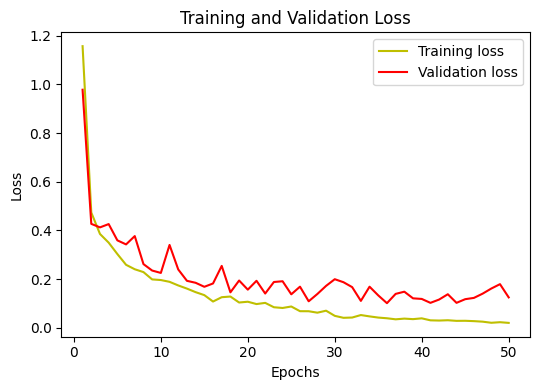

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.savefig('TV_Loss.png')
plt.show()

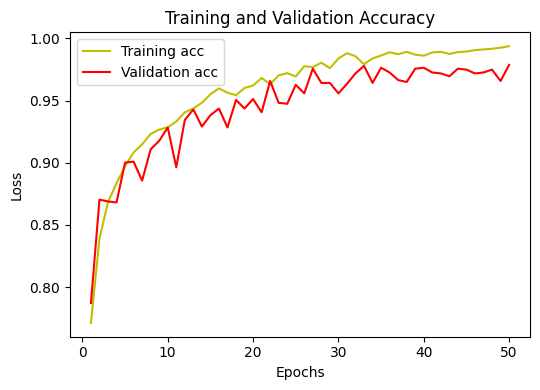

In [31]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.savefig('TV_Acc.png')
plt.show()

In [32]:
import sys

# Save model summary to a text file
with open('model_summary.txt', 'w') as f:
    # Redirect stdout to the text file
    sys.stdout = f
    # Print the model summary
    model.summary()
    # Reset stdout to the console
    sys.stdout = sys.__stdout__

print("Model summary saved as 'model_summary.txt'")

Model summary saved as 'model_summary.txt'
41/41 [==============================] - 7s 168ms/step - loss: 0.1251 - accuracy: 0.9786
Train Loss: 0.0313
Train Accuracy: 99.60%
--------------------
Validation Loss: 0.1251
Validation Accuracy: 97.86%
Scores saved successfully.
Data saved to training_metrics.json
Found 5712 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
                   TPR       FPR
Glioma        0.930000  0.010638
Meningioma    0.983660  0.062305
No Tumor      0.997531  0.002469
Pituitary     0.996667  0.013201
accuracy      0.978642  0.021358
macro avg     0.976964  0.022154
weighted avg  0.978642  0.020761
TPR and FPR saved as JSON.


In [33]:
model.save('VGG19+RNN.keras')

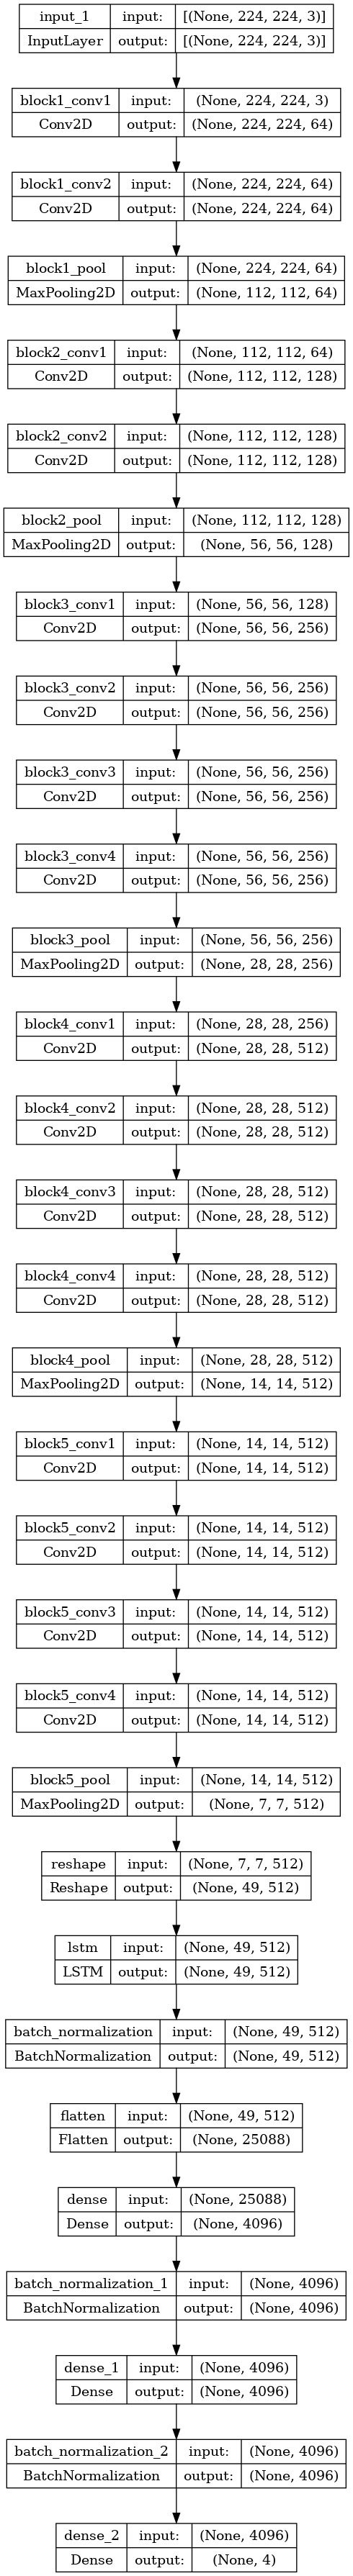

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
report = classification_report(y_labels, pred_classes, target_names=target_names, digits=4, output_dict= True)

report_df = pd.DataFrame(report).transpose()

precision = report_df['precision']
recall = report_df['recall']
f1_score = report_df['f1-score']
classes = report_df.index

# Calculate TPR and FPR for each class
tpr = recall
fpr = 1 - precision

# Save TPR and FPR to a DataFrame
tpr_fpr_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr}, index=classes)


tpr_fpr_json = tpr_fpr_df.to_json(orient='index')
print(tpr_fpr_df)
# Write JSON to file
with open('tpr_fpr.json', 'w') as f:
    json.dump(tpr_fpr_json, f)

print("TPR and FPR saved as JSON.")